Short term plasticity
=====================



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../../')

import torch
from time import perf_counter

from src.network import Network
from src.plasticity import Plasticity
from src.decode import decode_bump

REPO_ROOT = '/home/leon/models/NeuroTorch/'

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Testing STP implementation



### From the Plasticity class in src/plasticity.py



First, I we will plot the dynamics of the stp variables for a neuron with a given rate and Gaussian temporal noise.



In [1]:
tau_list = torch.tensor([0.5, 0.25])
N_BATCH = 2

stp = Plasticity(USE=0.03, TAU_FAC=tau_list, TAU_REC=0.2, DT=0.01, size=(2, 10))

N_STEPS = 500

A_ux = []
u_stp = []
x_stp = []

for _ in range(N_STEPS):
    rate = 10 + 10 * torch.randn((2, 10), device='cuda')

    A_ux.append(stp(rate))
    u_stp.append(stp.u_stp)
    x_stp.append(stp.x_stp)

A_ux = torch.stack(A_ux, dim=1).cpu().numpy()
u_stp = torch.stack(u_stp, dim=1).cpu().numpy()
x_stp = torch.stack(x_stp, dim=1).cpu().numpy()
print(A_ux.shape, u_stp.shape, x_stp.shape)

(2, 500, 10) (2, 500, 10) (2, 500, 10)

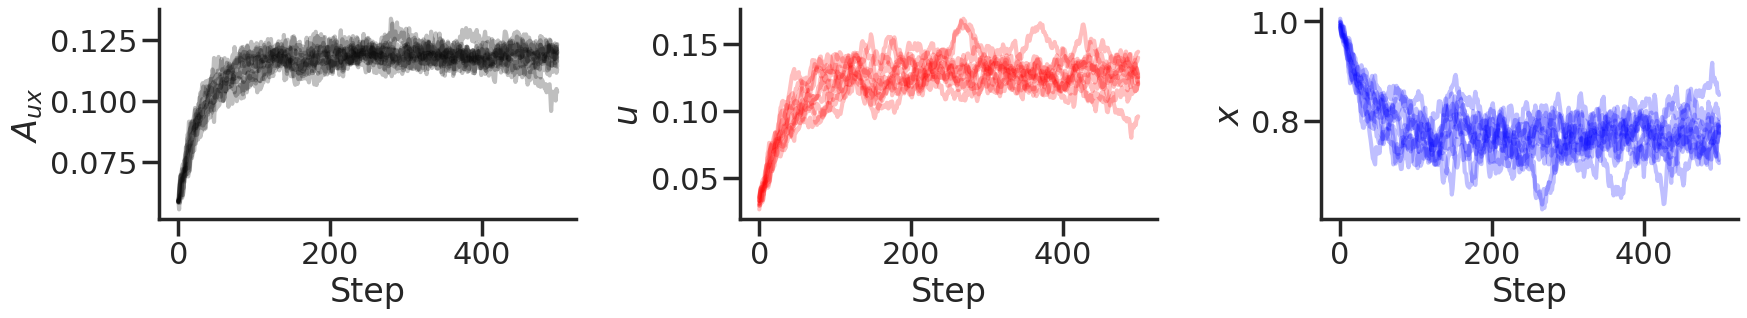

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(3*width, height))

ax[0].plot(A_ux[0, :], 'k', label='Aux', alpha=0.25)
ax[1].plot(u_stp[0, :], 'r', label='u', alpha=0.25)
ax[2].plot(x_stp[0, :], 'b', label='x', alpha=0.25)

ax[0].set_xlabel('Step')
ax[0].set_ylabel('$A_{ux}$')

ax[1].set_xlabel('Step')
ax[1].set_ylabel('$u$')

ax[2].set_xlabel('Step')
ax[2].set_ylabel('$x$')

plt.show()

Then I will look at the evolution of the steady state value of A<sub>ux</sub> with the rate for different values of tau<sub>fac</sub>



In [1]:
tau_list = torch.tensor([1.0, .75, .5, .25])
N_BATCH = tau_list.shape[0]

stp = Plasticity(USE=0.03, TAU_FAC=tau_list, TAU_REC=0.2, DT=0.01, size=(N_BATCH, 10))

In [1]:
A_ux = []
x = []
u = []

N_RATES = 100
N_STEPS = 300

for i in range(N_RATES): # firing rate
    rates = i + np.sqrt(i) * torch.randn((N_BATCH, N_STEPS, 10), device='cuda')
    for j in range(N_STEPS): # steps before convergence
        A_u_x = stp(rates[:, j])
    A_ux.append(A_u_x)
    u.append(stp.u_stp)
    x.append(stp.x_stp)

A_ux = torch.stack(A_ux, dim=1).cpu().numpy()
u = torch.stack(u, dim=1).cpu().numpy()
x = torch.stack(x, dim=1).cpu().numpy()
print(A_ux.shape, u.shape, x.shape)

(4, 100, 10) (4, 100, 10) (4, 100, 10)

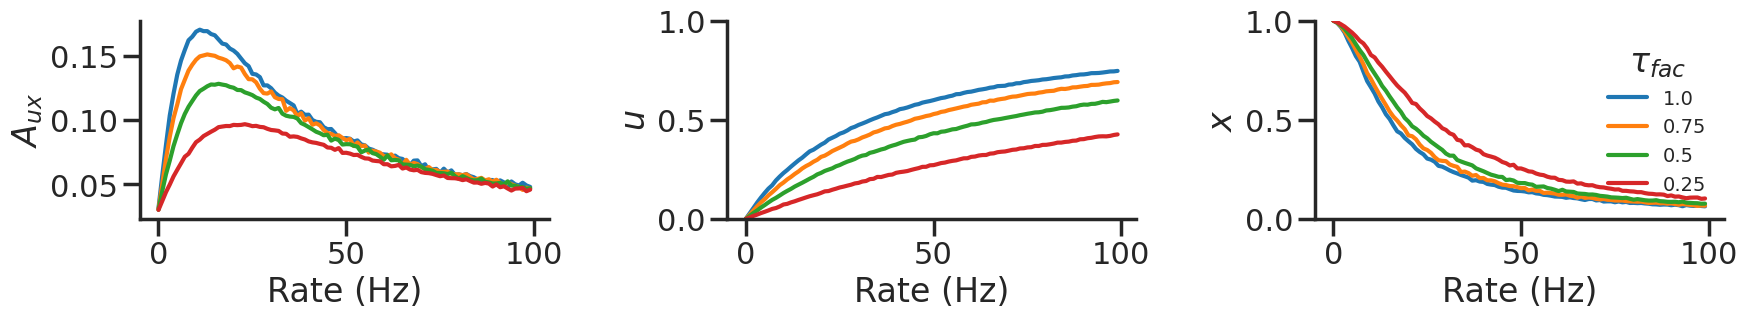

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[3*width, height])

ax[0].plot(A_ux.mean(-1).T, label=tau_list.cpu().numpy())
ax[0].set_xlabel('Rate (Hz)')
ax[0].set_ylabel('$A_{ux}$')

ax[1].plot(u.mean(-1).T, label=tau_list.cpu().numpy())
ax[1].set_xlabel('Rate (Hz)')
ax[1].set_ylabel('$u$')
ax[1].set_ylim([0, 1])

ax[2].plot(x.mean(-1).T, label=tau_list.cpu().numpy())
ax[2].set_xlabel('Rate (Hz)')
ax[2].set_ylabel('$x$')
ax[2].set_ylim([0, 1])
ax[2].legend(frameon=False, loc="right", fontsize=14, title='$\\tau_{fac}$')
plt.show()

This is what we expect!



### From the Network class in src/network.py



#### Single Trial



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr')
rates = model().cpu().detach().numpy()

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

(1, 151, 8000) (1, 151, 8000)

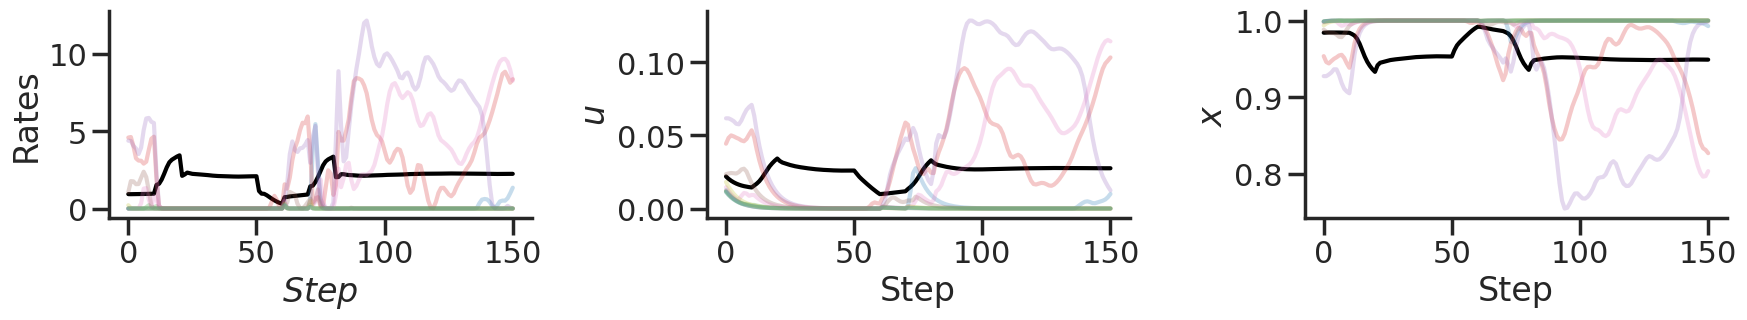

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[3*width, height])

ax[0].plot(rates.mean(-1).T, 'k')
ax[0].plot(rates[0, :, :10], alpha=.25)
ax[0].set_xlabel('$Step$')
ax[0].set_ylabel('Rates')

ax[1].plot(u_list.mean(-1).T, 'k')
ax[1].plot(u_list[0, :, :10], alpha=.25)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$u$')

ax[2].plot(x_list.mean(-1).T, 'k')
ax[2].plot(x_list[0, :, :10], alpha=.25)
ax[2].set_xlabel('Step')
ax[2].set_ylabel('$x$')

plt.show()

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(1, 151)

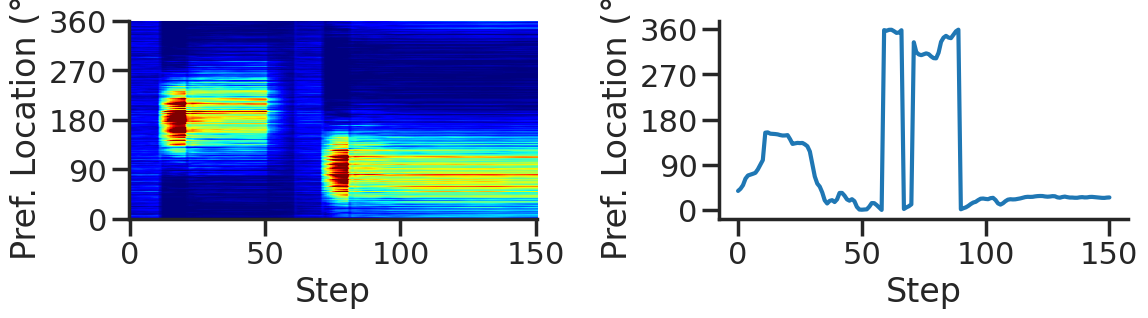

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(rates.T, aspect='auto', cmap='jet', vmin=0, vmax=10, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi[0] * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=1.0, VERBOSE=0, TASK='odr')
model.LIVE_FF_UPDATE = 1
PHI0 = model.PHI0.unsqueeze(0).unsqueeze(-1).repeat((8, 1, 1))
PHI0[:, -1] = torch.linspace(45, 360, 8).unsqueeze(1)
print(PHI0.shape)

torch.Size([8, 3, 1])

In [1]:
model.PHI0 = PHI0
model.N_BATCH = 8
rates = model().cpu().detach().numpy()
print(rates.shape)

(8, 151, 8000)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(8, 151)

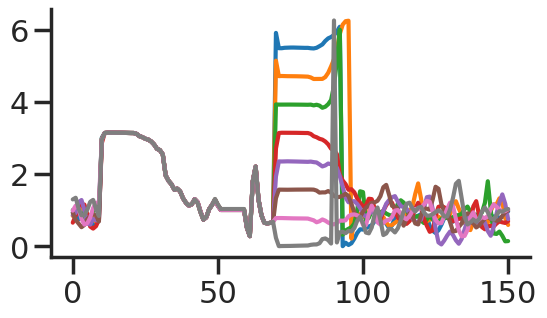

In [1]:
plt.plot(phi.T)
plt.show()

In [1]:
PHI1_list = np.linspace(45, 360, 8)
print(PHI1_list)

model.N_BATCH = 10

ff_inputs = []
for i in PHI1_list:
    model.PHI0[-1] = i  # here we set the ff input to E to value i in 0 .. 10      
    ff_inputs.append(model.init_ff_input())

ff_inputs = torch.vstack(ff_inputs)
print(ff_inputs.shape)

[ 45.  90. 135. 180. 225. 270. 315. 360.]
torch.Size([80, 16100, 1000])

#### Rates vs Ie



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=0.5, VERBOSE=0)

In [1]:
Je0_list = np.linspace(0, 10, 10)
print(Je0_list)

ff_inputs = []
for i in Je0_list:
    model.Ja0[:, 0] = i  # here we set the ff input to E to value i in 0 .. 10      
    ff_inputs.append(model.init_ff_input())

ff_inputs = torch.vstack(ff_inputs)

[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]

In [1]:
rates_Je0 = model(ff_inputs).cpu().detach().numpy()

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

(10, 101, 8000) (10, 101, 8000)

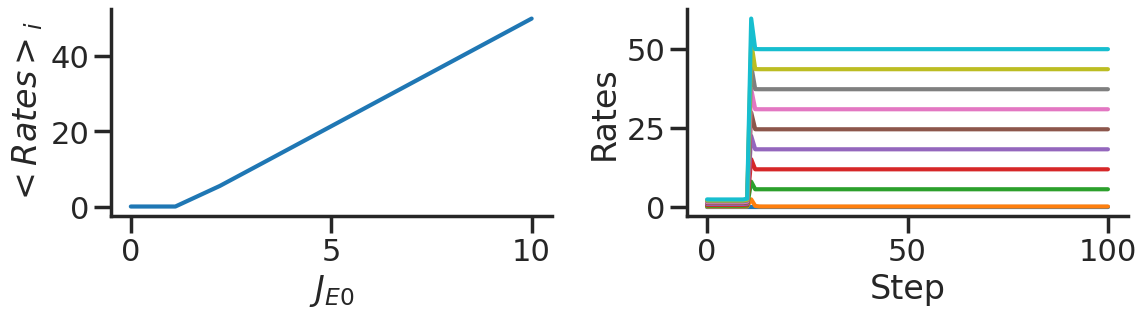

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_Je0[:,-1].mean(-1)

ax[0].plot(Je0_list, mean_rates)
ax[0].set_xlabel('$J_{E0}$')
ax[0].set_ylabel('$<Rates>_i$')
# ax[0].set_ylim([0, 60])

ax[1].plot(rates_Je0.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Rates')
# ax[1].set_ylim([0, 60])
plt.show()

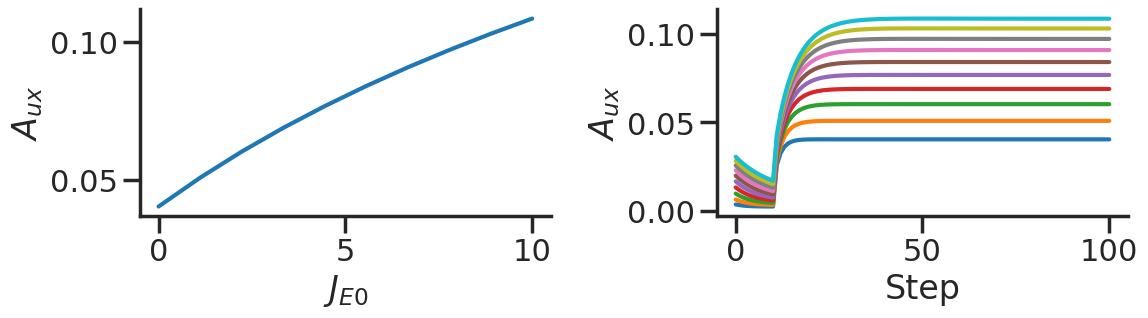

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = u_list[:,-1].mean(-1) * x_list[:,-1].mean(-1)

ax[0].plot(Je0_list, mean_rates)
ax[0].set_xlabel('$J_{E0}$')
ax[0].set_ylabel('$A_{ux}$')

ax[1].plot(u_list.mean(-1).T * x_list.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$A_{ux}$')

plt.show()

#### Rates vs Jee



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=0.5, VERBOSE=0)

In [1]:
model.IF_BATCH_J = 1

Jee_list = torch.linspace(0.5, 3, 10, device='cuda')
model.Jab_batch = Jee_list.unsqueeze(-1) * model.Jab[0, 0]

model.IF_STP = 1
model.N_BATCH = model.Jab_batch.shape[0]
model.VERBOSE = 0

rates_Jee = model().cpu().detach().numpy()

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

(10, 101, 8000) (10, 101, 8000)

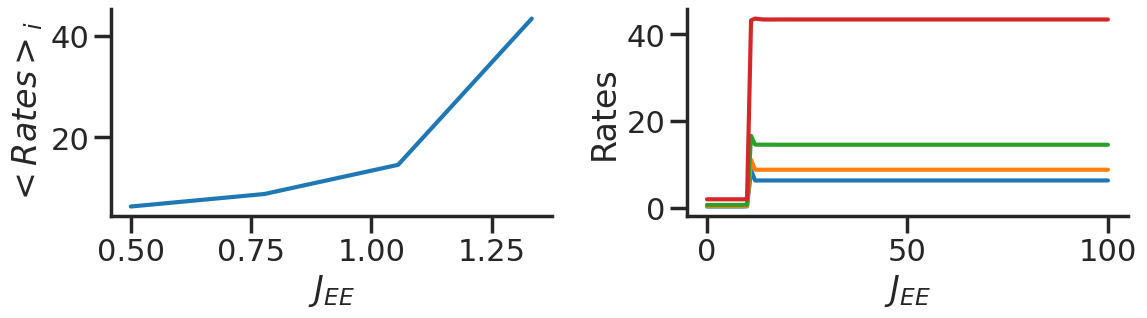

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_Jee[:,-1].mean(-1)

ax[0].plot(Jee_list.cpu().numpy(), mean_rates)
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$<Rates>_i$')
# ax[0].set_ylim([0, 60])

ax[1].plot(rates_Jee.mean(-1).T)
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('Rates')
# ax[1].set_ylim([0, 60])
plt.show()

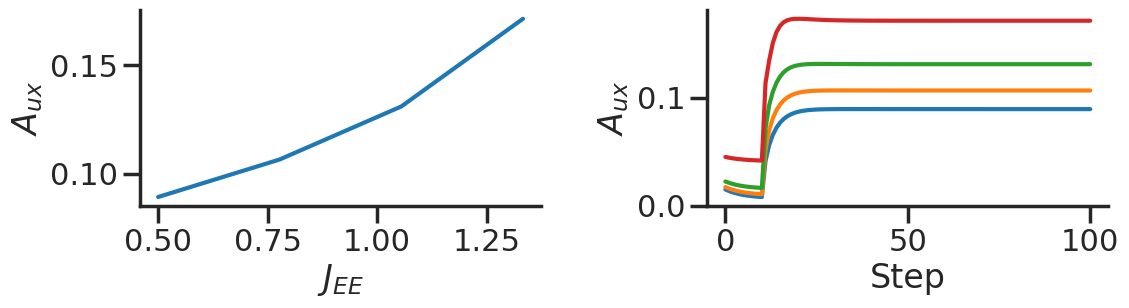

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = u_list[:,-1].mean(-1) * x_list[:,-1].mean(-1)

ax[0].plot(Jee_list.cpu(), mean_rates)
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$A_{ux}$')

ax[1].plot(u_list.mean(-1).T * x_list.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$A_{ux}$')

plt.show()

#### Rates vs Use



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=0.5, VERBOSE=0)

In [1]:
model.USE = torch.linspace(0.01, 0.1, 10, device='cuda')
model.N_BATCH = model.USE.shape[0]

rates_use = model(RET_STP=1).cpu().detach().numpy()
print(rates_use.shape)

(10, 111, 8000)

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

(10, 111, 8000) (10, 111, 8000)

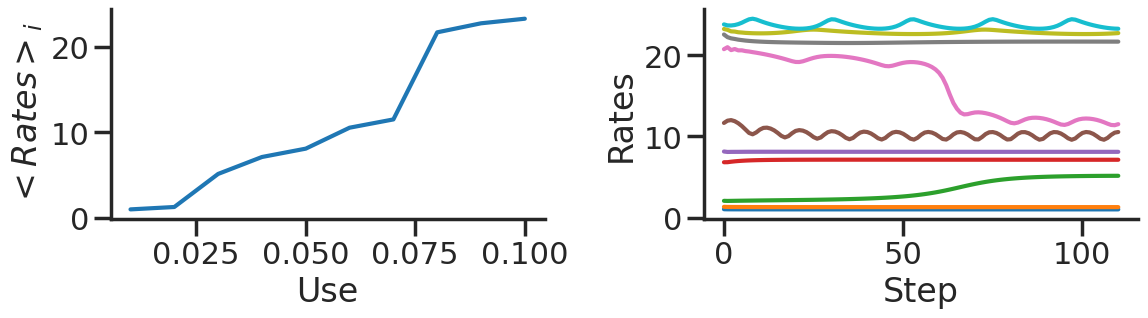

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_use[:,-1].mean(-1)

ax[0].plot(model.USE.cpu().numpy(), mean_rates)
ax[0].set_xlabel('Use')
ax[0].set_ylabel('$<Rates>_i$')
# ax[0].set_ylim([0, 60])

ax[1].plot(rates_use.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Rates')
# ax[1].set_ylim([0, 60])
plt.show()

# [goto error]
#+begin_example
  ---------------------------------------------------------------------------
  ValueError                                Traceback (most recent call last)
  Cell In[13], line 9
        6 ax[0].set_xlabel('$Use$')
        7 ax[0].set_ylabel('$A_{ux}$')
  ----> 9 ax[1].plot(model.USE.cpu().numpy(), u_list.mean(-1).T * x_list.mean(-1).T)
       10 ax[1].set_xlabel('Step')
       11 ax[1].set_ylabel('$A_{ux}$')

  File ~/mambaforge/envs/torch/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1721, in Axes.plot(self, scalex, scaley, data, *args, **kwargs)
     1478 """
     1479 Plot y versus x as lines and/or markers.
     1480 
     (...)
     1718 (``'green'``) or hex strings (``'#008000'``).
     1719 """
     1720 kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)
  -> 1721 lines = [*self._get_lines(self, *args, data=data, **kwargs)]
     1722 for line in lines:
     1723     self.add_line(line)

  File ~/mambaforge/envs/torch/lib/python3.10/site

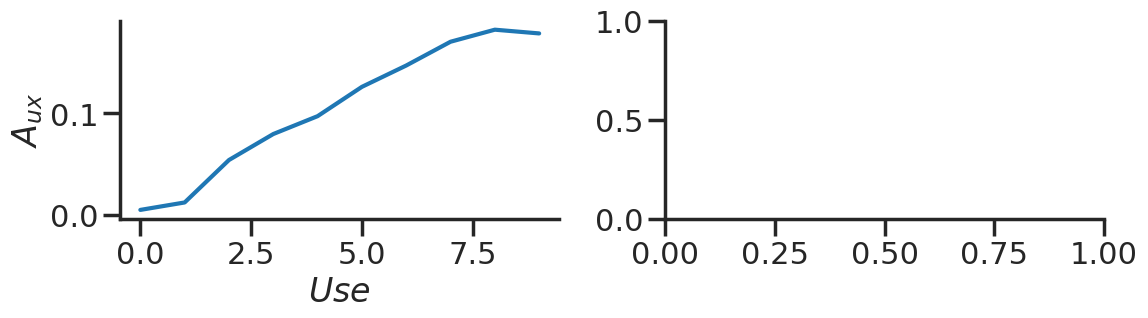

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = u_list[:,-1].mean(-1) * x_list[:,-1].mean(-1)

ax[0].plot(mean_rates)
ax[0].set_xlabel('$Use$')
ax[0].set_ylabel('$A_{ux}$')

ax[1].plot(model.USE.cpu().numpy(), u_list.mean(-1).T * x_list.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$A_{ux}$')

plt.show()

#### Rates vs Tau fac



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=1, DT=0.001, GAIN=0.5, VERBOSE=0, DURATION=10)

In [1]:
model.TAU_FAC = torch.linspace(0.25, 1.0, 10, device='cuda')
model.N_BATCH = model.TAU_FAC.shape[0]

rates_fac = model().cpu().detach().numpy()
print(rates_fac.shape)

(10, 101, 8000)

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
print(u_list.shape, x_list.shape)

(10, 101, 8000) (10, 101, 8000)

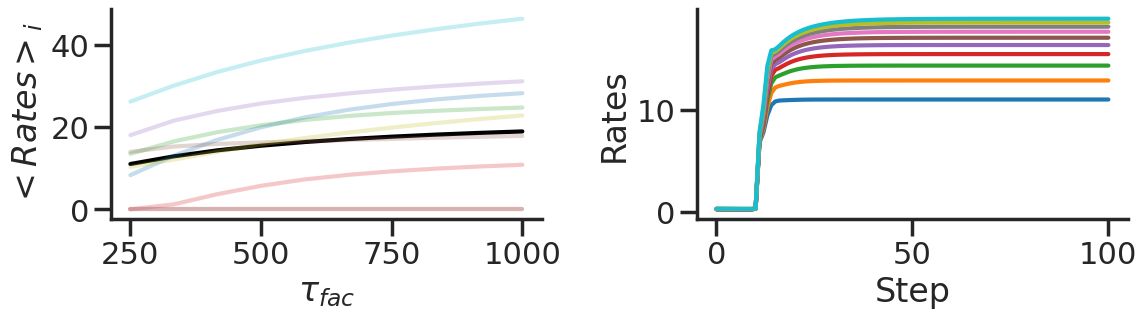

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_fac[:,-1].mean(-1)

ax[0].plot(model.TAU_FAC.cpu().numpy()*1000, mean_rates, 'k')
ax[0].plot(model.TAU_FAC.cpu().numpy()*1000, rates_fac[:, -1, :10], alpha=.25)
ax[0].set_xlabel('$\\tau_{fac}$')
ax[0].set_ylabel('$<Rates>_i$')

ax[1].plot(rates_fac.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Rates')
plt.show()

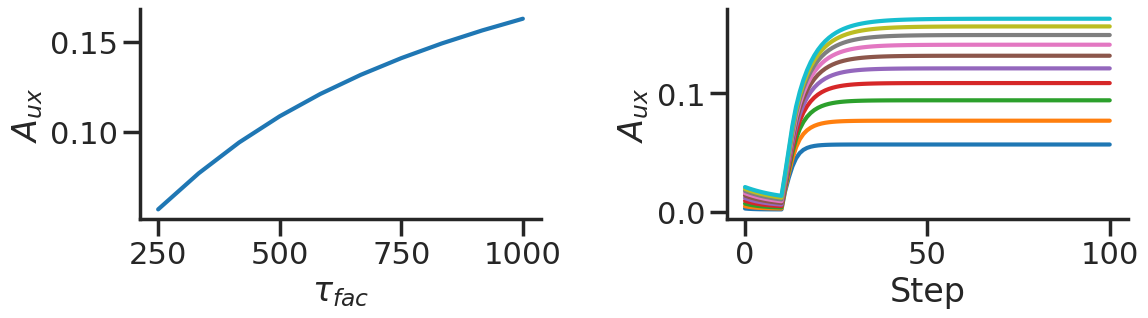

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_Aux = u_list[:,-1].mean(-1) * x_list[:,-1].mean(-1)

ax[0].plot(model.TAU_FAC.cpu().numpy() * 1000, mean_Aux)
ax[0].set_xlabel('$\\tau_{fac}$')
ax[0].set_ylabel('$A_{ux}$')

ax[1].plot(u_list.mean(-1).T * x_list.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$A_{ux}$')

plt.show()